In [1]:
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_floats_after_substring(text, substring):
    # Create a pattern to match the substring followed by a float number
    pattern = re.compile(rf'{re.escape(substring)}\s*(-?\d+\.\d+)')
    matches = pattern.findall(text)
    return matches

def print_min_max_avg_perf(indata, cohort_name):
    min_v = indata['perc_tile_postive'].min()
    print(f'{cohort_name} % of pos min is : {min_v:0.4f}')
    max_v = indata['perc_tile_postive'].max()
    print(f'{cohort_name} % of pos max is : {max_v:0.4f}')
    avg_v = indata['perc_tile_postive'].mean()
    print(f'{cohort_name} % of pos  avg is : {avg_v:0.4f}')

In [3]:
proj_dir = '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/'
csv_location =  proj_dir + '/intermediate_data/cd_finetune/cancer_detection_training/ccola_opx_retrain_alldata_list.csv' 
patch_location = proj_dir + '/intermediate_data/cd_finetune/cancer_detection_training/patches/'
save_path = proj_dir + '/intermediate_data/cd_finetune/cancer_detection_training/'

In [4]:
#Load all sample list
sp_list_df = pd.read_csv(csv_location)
flist = sp_list_df['filename']
sp_list_df['sample_id'] = [x.split('.')[0] for x in flist]

#Add cohort name
sp_list_df['Cohort'] = 'CCOLA'
opx_cond = sp_list_df['filename'].str.contains('OPX', case=False, na=False)
sp_list_df.loc[opx_cond,'Cohort'] = 'OPX'
sp_list_df['Cohort'].value_counts()

opx_ids = sp_list_df.loc[sp_list_df['Cohort'] == 'OPX','sample_id']

#Add if METs or Local (All Ccola are met)
sp_list_df['MET_OR_LOCAL'] = 'MET' 

#load OPX mutation site
mut_site_df = pd.read_excel(proj_dir + 'data/MutationCalls/OPX_anatomic sites.xlsx')
local_ids = list(mut_site_df.loc[mut_site_df['Anatomic site']== 'Prostate', 'OPX_Number'])

#Assign local
sp_list_df.loc[sp_list_df['sample_id'].isin(local_ids),'MET_OR_LOCAL'] = 'LOCAL'

In [5]:
#Get all generated mask and tile files, get tumor fraction and, if it is a tumor tile
all_file_df_list = []
for index, row in sp_list_df.iterrows():
    cur_id = row['sample_id']
    cur_all_fs = os.listdir(os.path.join(patch_location,cur_id))
    cur_mask_fs =  [x for x in cur_all_fs if 'mask' in x] #all mask files
    cur_tiles_fs = [x for x in cur_all_fs if 'mask' not in x]   #all tile files
    cur_tiles_tf = [float(extract_floats_after_substring(x, 'tumor-')[0]) for x in cur_tiles_fs] #all tumor fraction
    cur_df = pd.DataFrame({'sample_id': cur_id,'img': cur_tiles_fs, 'label': cur_mask_fs, 'tumor_fraction': cur_tiles_tf}) 
    #Get label is tumor
    cur_df['is_tumor_tile'] = 0
    cur_df.loc[cur_df['tumor_fraction']>0,'is_tumor_tile'] = 1
    all_file_df_list.append(cur_df)
all_file_df = pd.concat(all_file_df_list)
all_file_df['img'] =  patch_location + all_file_df['sample_id'] + '/' + all_file_df['img']
all_file_df['label'] =  patch_location + all_file_df['sample_id'] + '/' + all_file_df['label']

In [6]:
#for each sample id, compute total tiles and tumor files
total_tile_df = all_file_df.groupby('sample_id').size().reset_index(name='n_tiles_total')
pos_tile_df = all_file_df.groupby('sample_id')['is_tumor_tile'].sum().reset_index(name='n_tiles_postive')

#Comb
sp_list_df = sp_list_df.merge(total_tile_df,on = 'sample_id')
sp_list_df = sp_list_df.merge(pos_tile_df,on = 'sample_id')

#Add % of pos tile
sp_list_df['perc_tile_postive'] = sp_list_df['n_tiles_postive']/sp_list_df['n_tiles_total']

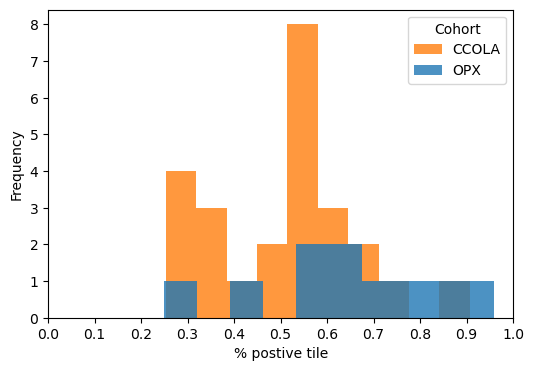

All % of pos min is : 0.2481
All % of pos max is : 0.9596
All % of pos  avg is : 0.5470
OPX % of pos min is : 0.2481
OPX % of pos max is : 0.9596
OPX % of pos  avg is : 0.6486
CCOLA % of pos min is : 0.2529
CCOLA % of pos max is : 0.9068
CCOLA % of pos  avg is : 0.5063


In [7]:
# Group the data by gender
grouped = sp_list_df.groupby('Cohort')
colors = {'OPX': 'tab:blue', 'CCOLA': 'tab:orange'}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histograms for each gender
for name, group in grouped:
    group['perc_tile_postive'].plot.hist(ax=ax, alpha=0.8, label=name, bins=10, color=colors[name])

# Add legend and labels
ax.legend(title='Cohort')
ax.set_xlabel('% postive tile')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 1])
ax.set_xticks([float('0.' + str(x)) for x in range(0,10,1)] + [1])
plt.show()



#for opx
opx_df = sp_list_df.loc[sp_list_df['Cohort'] == 'OPX']

#for ccola
ccola_df = sp_list_df.loc[sp_list_df['Cohort'] == 'CCOLA']


print_min_max_avg_perf(sp_list_df, 'All')
print_min_max_avg_perf(opx_df, 'OPX')
print_min_max_avg_perf(ccola_df, 'CCOLA')

In [8]:
# Generate train and test (70-30)
#Make sure:
#1. Train and test has data from two different cohort
#2. Has balcaned postive and negative tiles
rs = 22
x =  sp_list_df
y =  sp_list_df['perc_tile_postive']
y_binned = pd.cut(y, bins=2, labels=False)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y_binned, random_state=rs)

print(X_train['Cohort'].value_counts())
print(X_test['Cohort'].value_counts())

print_min_max_avg_perf(X_train, 'Train')
print("----------")
print_min_max_avg_perf(X_test, 'Test')


print("Percentage of postive tiles")
train_perc = X_train['n_tiles_postive'].sum() / X_train['n_tiles_total'].sum()
test_perc = X_test['n_tiles_postive'].sum() / X_test['n_tiles_total'].sum()
all_perc = sp_list_df['n_tiles_postive'].sum() / sp_list_df['n_tiles_total'].sum()

print(rs, ": Train: %0.2f"  % train_perc)
print(rs, ": Test: %0.2f"  % test_perc)
print(rs, ": All: %0.2f"  % all_perc)

#Get IDs
train_ids = list(X_train['sample_id'])
test_ids = list(X_test['sample_id'])

Cohort
CCOLA    17
OPX       7
Name: count, dtype: int64
Cohort
CCOLA    8
OPX      3
Name: count, dtype: int64
Train % of pos min is : 0.2481
Train % of pos max is : 0.9596
Train % of pos  avg is : 0.5336
----------
Test % of pos min is : 0.2529
Test % of pos max is : 0.9068
Test % of pos  avg is : 0.5760
Percentage of postive tiles
22 : Train: 0.64
22 : Test: 0.62
22 : All: 0.63


In [9]:
#Get final input to fine-tune model
all_file_df['is_valid'] = pd.NA
cond = all_file_df['sample_id'].isin(train_ids)
all_file_df.loc[cond,'is_valid'] = False
cond = all_file_df['sample_id'].isin(test_ids)
all_file_df.loc[cond,'is_valid'] = True
all_file_df = all_file_df[['img','label','is_valid']]
print(all_file_df['is_valid'].value_counts())

all_file_df.to_csv(save_path + 'training_file.csv', index = False)

is_valid
False    14863
True      4856
Name: count, dtype: int64


In [10]:
#Output tf info df
sp_list_df['Train_OR_Test'] = pd.NA
cond = sp_list_df['sample_id'].isin(train_ids)
sp_list_df.loc[cond,'Train_OR_Test'] = "Train"
cond = sp_list_df['sample_id'].isin(test_ids)
sp_list_df.loc[cond,'Train_OR_Test'] = "Test"
print(sp_list_df['Train_OR_Test'].value_counts())

sp_list_df.to_csv(save_path + 'all_tumor_fraction_info.csv', index = False)

Train_OR_Test
Train    24
Test     11
Name: count, dtype: int64
